## Initialization

In [1]:
storageName = 'university'

if storageName == 'paperspace': 
    guy_folder = "/notebooks/"
elif storageName == 'colab':
    guy_folder = "/content/"
elif storageName == 'university':
    guy_folder = '/vol/scratch/guy/'
    
    
cache_dir = guy_folder+"/cache/transformer_cache"

In [ ]:
%pip install --no-cache-dir datasets

## Imports

In [41]:
cache_dir = guy_folder + "/torch-transformers-cache/"
import torch
import sklearn # Order important - torch before sklearn (had to install and uninstall stuff until worked, not sure why)
from tokenizers import Tokenizer
import transformers
from transformers import AutoModel, AutoTokenizer, pipeline
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import re, pdb
import itertools
%matplotlib inline
%cd {guy_folder}

from tqdm import tqdm_notebook, trange, tqdm
from torch.functional import F
from torch import nn
from torch.nn import Sequential
from torch.nn import Linear
from torch.utils.data import Dataset, DataLoader
import scipy
import wandb
from functools import partial
from datasets import load_dataset
from transformers import AdamW
device = 'cpu'

/specific/scratches/scratch/guy


In [42]:
%cd ~/Documents/nlp-experiments/

/specific/a/home/cc/students/cs/dar/Documents/nlp-experiments


In [43]:
%run ./utils.ipynb

## Functions

In [36]:
modelName = "distilbert-base-cased"

def _introduceBinLinear(m_, with_fc):
    children = m_.named_children()
    lin_names = ['k_lin', 'q_lin', 'v_lin', 'out_lin']
    if with_fc:
         lin_names += ['lin1', 'lin2']
    for name, m in children:
        if name in lin_names:
            m_.__setattr__(name, BinLinear(m.weight, m.bias))

In [37]:
class Binarizer(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, threshold):
        output = (input > threshold).float()        
        return output

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None


class BinLinear(nn.Module):
    threshold = .5
    def __init__(self, originalWeight, originalBias, initialSparsity = .7, threshold = None):
        # Notice positivity of the mask is not warranated
        super().__init__()
        shape = originalWeight.shape
        self.threshold = threshold
        self.originalWeight = originalWeight
        self.originalBias = originalBias

        self.rawMask = nn.Parameter(torch.rand(*shape) * self._sparsityMask(initialSparsity, shape))
    
    def forward(self, x):
        w = self.originalWeight * Binarizer.apply(self.rawMask, self.getThreshold())
        output = x @ (w.t()) 
        if self.originalBias is not None:
            output += self.originalBias
        return output
    
    def _sparsityMask(self, initialSparsity, shape):
        return (torch.rand(*shape) > initialSparsity).float()
    
    def extra_repr(self):
        rep = '{}, {}'.format(*self.rawMask.t().shape)
        if self.originalBias is not None:
            rep += ', bias = True'
        return rep
    
    def getThreshold(self):
        if self.threshold is None:
            return BinLinear.threshold
        else:
            return self.threshold

        
    def getMask(self):
        return (self.rawMask > self.getThreshold()).long()


class BinBert(nn.Module):
    def __init__(self, n_classes = None, 
                 with_fc = True, pool = False):
        super().__init__()
        assert((not pool) or (n_classes is not None))
        self.pool = pool
        self.body = AutoModel.from_pretrained(modelName, cache_dir = cache_dir)
        self.body.requires_grad_(False)
        self.body.apply(partial(_introduceBinLinear, with_fc = with_fc));
        if n_classes is not None:
            shape = (768, n_classes)
            self.label_fc = BinLinear(nn.Parameter(torch.rand(*shape).t()),
                                    nn.Parameter(torch.rand(shape[1])))
    def forward(self, **inputs):
        output, = self.body(**inputs)
        if hasattr(self, 'label_fc'):
            output = self.label_fc(output)
            if self.pool: 
                output = output[:, 0]
        return output

    def setMaskTrainability(self, requires_grad):
        def _changeMaskTrainability(m):
            if isinstance(m, BinLinear):
                m.rawMask.requires_grad_(requires_grad)
        self.apply(_changeMaskTrainability)
        
    def iterMasks(self):
        return map(lambda x: x[1], filter(lambda x: x[0].endswith('.rawMask'), self.named_parameters()))
    
    def _randomizeSimpleMask(self, mask, sparsity):
        with torch.no_grad():
            mask.uniform_()
            mask.set_((mask > sparsity).float())
        
    def randomizeSimpleMasks(self, sparsity):
        for mask in self.iterMasks():
            self._randomizeSimpleMask(mask, sparsity)
    
    
    def getLinear(self, i,  linName):
        assert((type(i) == int) and (linName in ['k_lin', 'q_lin', 'v_lin', 'out_lin', 'lin1', 'lin2']))
        if linName in ['lin1', 'lin2']:
            linName = 'ffn.' + linName
        else:
            linName = 'attention.' + linName
        linName = "." + str(i) + "." + linName
        return next(map(lambda x: x[1], 
                        filter(lambda x: (x[0].endswith(linName)), self.named_modules())
                       ))
    
    
    

## Main

In [38]:
n_classes = 7
tokenizer = AutoTokenizer.from_pretrained(modelName, cache_dir = cache_dir)
binBert = BinBert(n_classes, pool = True, with_fc = True)

In [39]:
state_dict = torch.load("../pretrained/binBert.pt")
binBert.load_state_dict(state_dict, strict = False);

In [44]:
batch_size = 1
emotionDict = {'sadness': 0, 'joy': 1, 'anger': 2, 'love': 3, 'fear': 4, 'love': 5, 
              'surprise': 6}
train_ds = TextDataset('emotion', split = 'train',
                       tokenizer = tokenizer, inputCol = 'text', targetCol = 'label',
                       transformTarget = lambda x: torch.tensor(emotionDict[x]).to(device)
                      )

train_dataloader = DataLoader(train_ds, batch_size = None, 
                              shuffle = True)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(binBert.parameters(), lr = 5e-6)
for epoch in range(10):
    running_loss = 0
    running_acc = 0

    pbar = tqdm(train_dataloader, position = 0, leave = True)
    for i, (inputs, y) in enumerate(pbar):
        yhat, = binBert(**inputs)
        loss = criterion(yhat.unsqueeze(0), y.unsqueeze(0))
        running_loss += loss.item() / batch_size
        running_acc += (yhat.argmax(-1) == y).sum().item() / batch_size
        pbar.set_postfix_str("Loss: {} Acc: {}".format(running_loss / (1+i), 
                                                       running_acc / (i + 1)
                                                      ))
        loss.backward()
        optimizer.step()

Using custom data configuration default
Reusing dataset emotion (/vol/scratch/guy//torch-transformers-cache/emotion/default/0.0.0/5276a3f9a2c014ee528f5cca7ad34f185b886acd0f60fe18c61c6768662ca828)
  1%|          | 146/16000 [00:33<59:57,  4.41it/s, Loss: 1.3603512302142422 Acc: 0.47619047619047616]  


KeyboardInterrupt: 

<Figure size 432x648 with 0 Axes>

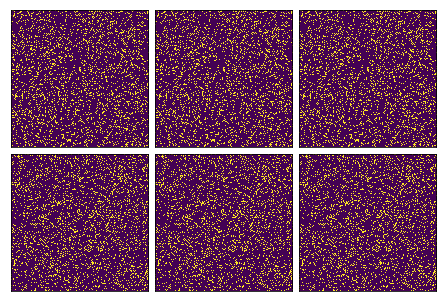

In [137]:
%matplotlib inline
plt.figure(figsize = (6,9))
fig, axes = plt.subplots(2, 3) #
for i in range(2):
    for j in range(3):
#     plt.subplot(2,3, i + 1)
        ax = axes[i][j]
        ax.matshow(binBert.getLinear(i, 'k_lin').getMask().cpu().detach().numpy())
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout(pad = 0, w_pad = 0);

## Visualization

In [51]:
v = np.zeros((100, 7))
ys = []
for i, (x, y) in enumerate(tqdm(train_ds, total = 100)):
    if i >= 100:
        break
    v[i] = (binBert(**x).detach().numpy())
    ys.append(y.item())

100%|██████████| 100/100 [00:08<00:00, 12.08it/s]


In [48]:
from sklearn.decomposition import PCA

pca = PCA(2)
values = pca.fit_transform(v)

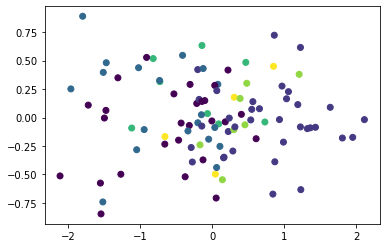

In [52]:
plt.scatter(values[:,0], values[:, 1], c = ys)

## Help

In [8]:
import gc
gc.collect()

20

In [167]:
[print("{}: {}".format(k, v.shape)) for k,v in binBert.named_parameters() if v.requires_grad];

body.transformer.layer.0.attention.q_lin.rawMask: torch.Size([768, 768])
body.transformer.layer.0.attention.k_lin.rawMask: torch.Size([768, 768])
body.transformer.layer.0.attention.v_lin.rawMask: torch.Size([768, 768])
body.transformer.layer.0.attention.out_lin.rawMask: torch.Size([768, 768])
body.transformer.layer.0.ffn.lin1.rawMask: torch.Size([3072, 768])
body.transformer.layer.0.ffn.lin2.rawMask: torch.Size([768, 3072])
body.transformer.layer.1.attention.q_lin.rawMask: torch.Size([768, 768])
body.transformer.layer.1.attention.k_lin.rawMask: torch.Size([768, 768])
body.transformer.layer.1.attention.v_lin.rawMask: torch.Size([768, 768])
body.transformer.layer.1.attention.out_lin.rawMask: torch.Size([768, 768])
body.transformer.layer.1.ffn.lin1.rawMask: torch.Size([3072, 768])
body.transformer.layer.1.ffn.lin2.rawMask: torch.Size([768, 3072])
body.transformer.layer.2.attention.q_lin.rawMask: torch.Size([768, 768])
body.transformer.layer.2.attention.k_lin.rawMask: torch.Size([768, 768]

In [168]:
from collections import OrderedDict
state_dict = OrderedDict()

for name, p in binBert.named_parameters():
    if p.requires_grad:
        state_dict[name] = p.data

In [170]:
torch.save( state_dict, "../pretrained/binBert.pt")

## Old

In [2]:
# import numpy as np
# import pandas as pd
# from functools import partial
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import torch
# import sklearn
# from torch import nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# import transformers
# from transformers import AutoModel, AutoTokenizer
# from transformers import AdamW
# from datasets import load_dataset
# %matplotlib inline

# device = 'cpu'